# The Mathematical Engineering of Deep Learning

by Benoit Liquet, Sarat Moka, and Yoni Nazarathy

Julia Jupyter Notebook for [Unit 5](https://deeplearningmath.org/convolutional-neural-networks.html).



In [1]:
using Metalhead
vgg = VGG19();

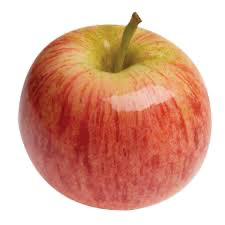

In [2]:
download("https://deeplearningmath.org/data/images/appleFruit.jpg","appleFruit.jpg");
img = load("appleFruit.jpg")

In [3]:
classify(vgg,img)

"Granny Smith"

---

# Basic image convolutions

In [ ]:
using Plots, Images; pyplot()

img = load("horse.jpg")
X = red.(img)*0.299 + green.(img)*0.587 + blue.(img)*0.114

heatmap(X, c=:Greys, yflip=true,legend=false)

In [ ]:
# The kernel
H = [0 -1 +1;
     0 -1 +1
     0 -1 +1];

In [ ]:
[sum(X[1:3,1:3] .* H)

In [ ]:
n,m = size(X)

In [ ]:
Y = [sum(X[i:i+2,j:j+2] .* H) for i in 1:n-4, j in 1:m-4];
heatmap(Y, c=:Greys, yflip=true,legend=false)

In [ ]:
using Statistics
Yf = Y .>= quantile(vec(Y),0.9);
heatmap(Yf, c=:Greys, yflip=true,legend=false)

---

In [ ]:
using Flux, Flux.Data.MNIST, Statistics, BSON, Random, Plots; pyplot()
using Flux: onehotbatch, onecold, crossentropy
Random.seed!(0)

epochs = 30
η = 5e-3
batchSize = 1000
trainRange, validateRange = 1:5000, 5001:10000

function minibatch(x, y, indexRange)
    xBatch = Array{Float32}(undef, size(x[1])..., 1, length(indexRange))
    for i in 1:length(indexRange)
        xBatch[:, :, :, i] = Float32.(x[indexRange[i]])
    end
    return (xBatch, onehotbatch(y[indexRange], 0:9))
end

trainLabels = MNIST.labels()[trainRange]
trainImgs = MNIST.images()[trainRange]
mbIdxs = Iterators.partition(1:length(trainImgs), batchSize)
trainSet = [minibatch(trainImgs, trainLabels, bi) for bi in mbIdxs]

validateLabels = MNIST.labels()[validateRange]
validateImgs = MNIST.images()[validateRange]
validateSet = minibatch(validateImgs, validateLabels, 1:length(validateImgs))

model1 = Chain(   flatten, 
                  Dense(784, 200, relu),
                  Dense(200, 100, tanh),
                  Dense(100, 10), 
                  softmax)

model2 = Chain(   Conv((5, 5),1=>8,relu,stride=(1,1),pad=(0,0)), 
                  MaxPool((2,2)),
                  Conv((3, 3),8=>16,relu,stride=(1,1),pad=(0,0)), 
                  MaxPool((2,2)),
                  flatten, 
                  Dense(400, 10), 
                  softmax)

opt1 = ADAM(η); opt2 = ADAM(η)
accuracyPaths = [[],[]]
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
loss(x, y, model) = crossentropy(model(x), y)
cbF1() = push!(accuracyPaths[1],accuracy(validateSet..., model1))
cbF2() = push!(accuracyPaths[2],accuracy(validateSet..., model2))

model1(trainSet[1][1]); model2(trainSet[1][1])
for _ in 1:epochs
    Flux.train!((x,y)->loss(x,y,model1), params(model1), trainSet, opt1, cb=cbF1)
    Flux.train!((x,y)->loss(x,y,model2), params(model2), trainSet, opt2, cb=cbF2)
	print(".")
end

println("\nModel1 (Dense) accuracy = ", accuracy(validateSet..., model1))
println("Model2 (Convolutional) accuracy = ", accuracy(validateSet..., model2))
cd(@__DIR__)
BSON.@save "mnistConv.bson" modelParams=cpu.(params(model2))
plot(accuracyPaths,label = ["Dense" "Convolutional"],
	ylim=(0.7,1.0), xlabel="Batch number", ylabel = "Validation Accuracy")

---

In [ ]:
using Metalhead

#downloads about 0.5Gb of a pretrained neural network from the web
vgg = VGG19();
for (i,layer) in enumerate(vgg.layers)
    println(i,":\t", layer)
end